<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
</center>

# [Projet machine learning](Projet-ML)

## Objectifs : 
<span style="color:  rgb(139, 0, 0)">**Notre projet consiste à analyser et faire des prédictions sur un jeu de données qui fournit un aperçu détaillé des routines d’exercice, des attributs physiques et des mesures de la condition physique des membres d’une salle de sport. Il y a deux objectifs principales pour ce projet :  Le premier objectif est de faire une analyse exploratoire des données pour bien cerner nos données. Dans un second temps, on effectuera deux modélisations avec la prédiction de calories brulées et du niveau d'expérience.**</span>

## Table des matières
1. [Analyse explorative des données (langage R)](#analyse-données)
   - Description général (natures des variables, encodages ...)
   - Analyse descriptive unidimensionnelle et bidimensionnelle
   - ACP des différentes variables
2. [Modélisation (langage R et python)](#modélisation)
   - Prédiction des calories brulées (régression)
   - Prédiction du niveau d'expérience (classification)
# 1. Analyse explorative des donées (langage R)
Cette partie se fera uniquement en R, l'analyse est dans l'autre notebook.

# 2. Modélisation (langage python)

# 2.1 Prédiction des calories brulées (régression)

README : ce qu'il reste à faire 

    -Sélections de variables et comparer sans (quasi fini)

    -Comparer en fonction du MSE, du R^2 score, des résidus et les courbes prédit/vrai (en cours)
    
    -Eventuellement optimiser quelques méthodes (arbres, réseaux ) attention long : faire sur le serveur GMM (peut-être des détails encore )

    -Interprétation  : 
Moins de variables → modèle plus simple → moins de variance captée
→ d’où un R² plus faible (moins de variance expliquée au total).

Mais moins de bruit aussi → prédictions plus robustes
→ d’où un MSE plus faible, car les erreurs absolues sont réduites (moins de sur-apprentissage).

Le modèle avec toutes les variables (sans sélection) :

Explique mieux la variance totale des données (R² ↑)

Mais surestime / surapprend certains points, ce qui augmente l’erreur moyenne (MSE ↑)

    -Faire réseaux de neuronnes profond 
    
    -Faire un boosting

## 2.1.1 Ajustement des données 

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
data=pd.read_csv("gym_members_exercise_tracking.csv",sep=",",header=0)
data.head()
data.dtypes
#On doit vérifier si les types sont bon, par exemple on va interpréter Experience_Level et Workout_Frequency comme des variables qualitatives avec des modalités. 

Age                                int64
Gender                            object
Weight (kg)                      float64
Height (m)                       float64
Max_BPM                            int64
Avg_BPM                            int64
Resting_BPM                        int64
Session_Duration (hours)         float64
Calories_Burned                  float64
Workout_Type                      object
Fat_Percentage                   float64
Water_Intake (liters)            float64
Workout_Frequency (days/week)      int64
Experience_Level                   int64
BMI                              float64
dtype: object

In [2]:
#Transformation de nos données au bon format voulu
data["Gender"]=pd.Categorical(data["Gender"],ordered=False)
data["Workout_Type"]=pd.Categorical(data["Workout_Type"],ordered=False)
data["Workout_Frequency (days/week)"]=pd.Categorical(data["Workout_Frequency (days/week)"],ordered=False)
data["Experience_Level"]=pd.Categorical(data["Experience_Level"],ordered=False)
data.dtypes

Age                                 int64
Gender                           category
Weight (kg)                       float64
Height (m)                        float64
Max_BPM                             int64
Avg_BPM                             int64
Resting_BPM                         int64
Session_Duration (hours)          float64
Calories_Burned                   float64
Workout_Type                     category
Fat_Percentage                    float64
Water_Intake (liters)             float64
Workout_Frequency (days/week)    category
Experience_Level                 category
BMI                               float64
dtype: object

In [3]:
data.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),BMI
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,49.840000


On va maintenant récupérer les variables explicatives en transformant les données de manière a pouvoir les utiliser en régression et classification. 

In [4]:
#Variables explicatives
################Variables qualitatives
dataDum=pd.get_dummies(data[["Gender","Workout_Type","Workout_Frequency (days/week)","Experience_Level"]]) 
# pour transformer des variables qualitatives en variables indicatrices, 
# chaque valeur unique de la variable qualitative devient une colonne distincte dans le DataFrame résultant

################Variables quantitatives
dataQuant=data[["Age","Weight (kg)","Height (m)","Max_BPM","Avg_BPM","Resting_BPM","Session_Duration (hours)","Fat_Percentage","Water_Intake (liters)","BMI"]] 

# Concaténation des variables explicatives
dfC=pd.concat([dataDum,dataQuant],axis=1)
dfC.head()
#print(type(dfC))
dfC.dtypes

Gender_Female                         bool
Gender_Male                           bool
Workout_Type_Cardio                   bool
Workout_Type_HIIT                     bool
Workout_Type_Strength                 bool
Workout_Type_Yoga                     bool
Workout_Frequency (days/week)_2       bool
Workout_Frequency (days/week)_3       bool
Workout_Frequency (days/week)_4       bool
Workout_Frequency (days/week)_5       bool
Experience_Level_1                    bool
Experience_Level_2                    bool
Experience_Level_3                    bool
Age                                  int64
Weight (kg)                        float64
Height (m)                         float64
Max_BPM                              int64
Avg_BPM                              int64
Resting_BPM                          int64
Session_Duration (hours)           float64
Fat_Percentage                     float64
Water_Intake (liters)              float64
BMI                                float64
dtype: obje

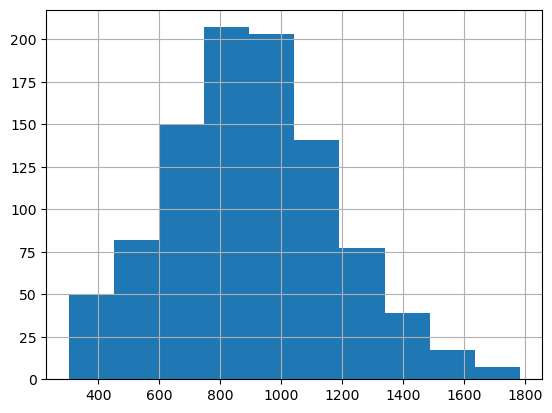

In [5]:
#Variables à prédire/expliquer 
YC=data["Calories_Burned"]
#print(type(YC))
YC.hist()
plt.show()

In [6]:
from sklearn.model_selection import train_test_split  
Lignes_Data=data.shape[0]
Colonnes_Data=data.shape[1]
Nbre_Element=data.size
#Séparation de notre jeu de données en 4 sous ensembles en 2 parties : parti test, parti train
Xc_train,Xc_test,YC_train,YC_test=train_test_split(dfC,YC,test_size=0.2,random_state=11) #test_size=0.2 indique qu'on prend 20%
#print(type(YC_train))

On va standardiser nos données, indispensables pour une utilisation efficase des algorithmes non linéaires : SVM, réseaux de neuronnes etc ...

In [7]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()  
scaler.fit(Xc_train)  
XC_train = scaler.transform(Xc_train)  
# Meme transformation sur le test
XC_test = scaler.transform(Xc_test)

## 2.2 Régression par modèles linéaires 

In [8]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

regLasso = linear_model.Lasso()
regLasso.fit(XC_train,YC_train)
prev=regLasso.predict(XC_test)
print("MSE=",mean_squared_error(YC_test,prev))

MSE= 1585.529698494295


In [9]:
from sklearn.metrics import r2_score
print("R2=",r2_score(YC_test,prev))

R2= 0.9813767896831493


Les fonctions de modèles linéaires et linéaires généralisés sont limitées dans [Scikit-learn](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) et sans sorties numériques (tests) détaillées. Il est préférable d'utiliser une autre librairie [StatsModels](http://statsmodels.sourceforge.net/stable/examples/notebooks/generated/glm.html) dont les sorties sont inspirées de celles de R. Dans les deux cas, les stratégies classiques (forward, backward, stepwise) de sélection de variables par optimisation d'un critère (Cp, AIC, BIC) ne semblent pas disponibles, même si AIC et BIC sont présents dans `scikit-learn`, et le type DataFrame (package `pandas`) n'est pas reconnu.

La façon efficace de procéder est donc d'introduire une [pénalisation Lasso](http://wikistat.fr/pdf/st-m-app-select.pdf) pour opérer une sélection de variables ou plutôt la sélection de variables quantitatives et d'indicatrices des modalités de celles qualitatives mais sans analyse fine des interactions comme cela est possible avec R.

Le paramètre de pénalisation Lasso est optimisé par validation croisée.

In [10]:
from sklearn.model_selection import GridSearchCV

# grille de valeurs du paramètre alpha à optimiser
param=[{"alpha":[0.4,0.5,1,1.2,1.3,1.4,1.5]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(XC_train, YC_train)
# paramètre optimal
regLassOpt.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))
##  Meilleur R2 = 0.977484, Meilleur paramètre = {'alpha': 1.3}

Meilleur R2 = 0.977484, Meilleur paramètre = {'alpha': 1.3}


In [11]:
prev=regLassOpt.predict(XC_test)
print("MSE=",mean_squared_error(prev,YC_test))
print("R2=",r2_score(YC_test,prev))  #très bonne corrélation 

# Coefficients
regLassoOpt=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso_Opt=regLassoOpt.fit(XC_train,YC_train)
print("Matric des coefficients=",model_lasso_Opt.coef_) #matrice des coefficients

coef = pd.Series(model_lasso_Opt.coef_, index = Xc_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))


MSE= 1587.4968465791533
R2= 0.9813536840847216
Matric des coefficients= [-4.10648020e+01  2.13637734e-13  2.41636599e-01 -0.00000000e+00
  0.00000000e+00 -2.17334753e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  5.05132750e-01 -1.48254769e-01  0.00000000e+00
  0.00000000e+00 -4.00426228e+01  1.16663901e+00  5.35938383e-01
 -0.00000000e+00  8.88559531e+01  6.64300419e-01  2.40676856e+02
 -8.56423688e-01  0.00000000e+00  0.00000000e+00]
Lasso conserve 13 variables et en supprime 10


In [12]:
# Variables retenues (coefficients non nuls)
coeff=model_lasso_Opt.coef_
retained_vars = [(var, coef) for var, coef in zip(dfC.columns, coeff) if coef != 0]

print("\nVariables retenues par Lasso (coefficients non nuls) :n=",len(retained_vars))
for var, coef in retained_vars:
    print(f"{var:30s} -> {coef:.4f}")


Variables retenues par Lasso (coefficients non nuls) :n= 13
Gender_Female                  -> -41.0648
Gender_Male                    -> 0.0000
Workout_Type_Cardio            -> 0.2416
Workout_Type_Yoga              -> -2.1733
Workout_Frequency (days/week)_5 -> 0.5051
Experience_Level_1             -> -0.1483
Age                            -> -40.0426
Weight (kg)                    -> 1.1666
Height (m)                     -> 0.5359
Avg_BPM                        -> 88.8560
Resting_BPM                    -> 0.6643
Session_Duration (hours)       -> 240.6769
Fat_Percentage                 -> -0.8564


Text(0.5, 1.0, 'Coefficients du modèle lasso')

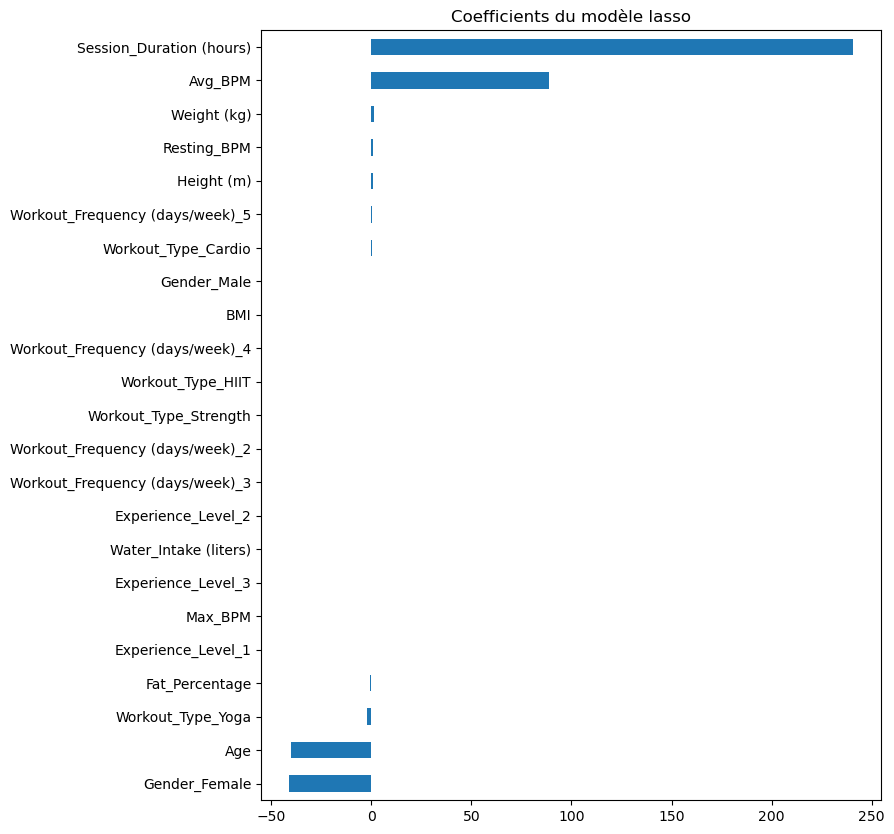

In [13]:
coef = pd.Series(coeff, index = Xc_train.columns)
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

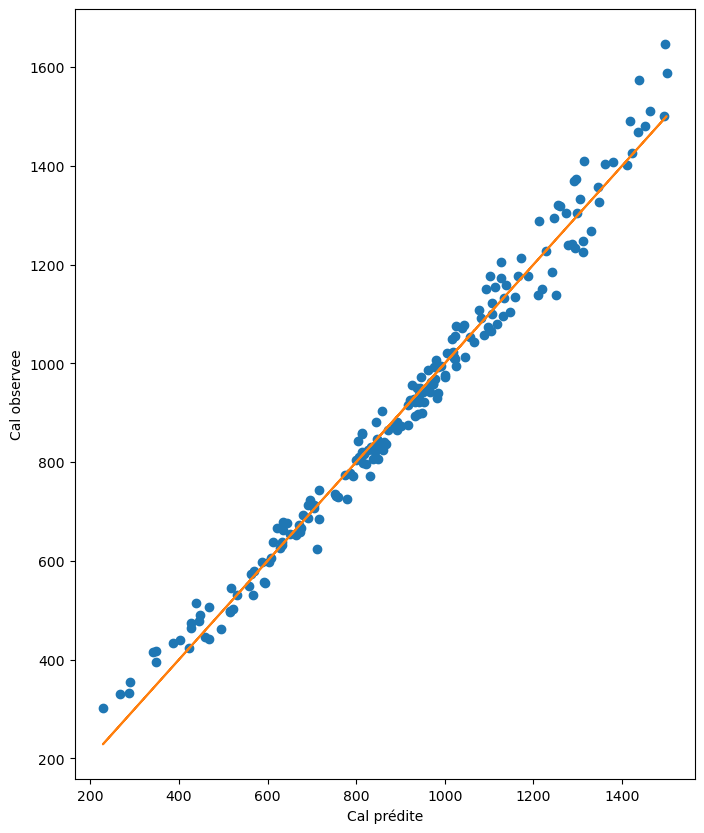

In [14]:
#Valeurs prédites contre les valeurs observées 
plt.plot(prev,YC_test,"o")
plt.plot(prev,prev)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.show()


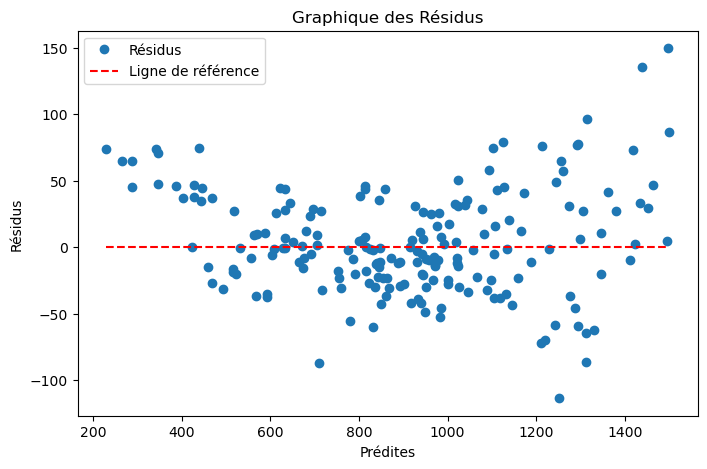

In [15]:
#print(type(YC_test))*
prev=regLassOpt.predict(XC_test)
residus=YC_test-prev
plt.figure(figsize=(8, 5))
plt.plot(prev,residus,"o",label='Résidus')
plt.xlabel(u"Prédites")
plt.ylabel(u"Résidus")
plt.hlines(0, min(prev), max(prev), colors='red', linestyles='dashed', label='Ligne de référence')
plt.legend()
plt.title("Graphique des Résidus")
plt.show()

Matrice de confusion avec seuillage

In [16]:
from sklearn.metrics import confusion_matrix

prev_continuous=np.copy(prev)
YC_test_continuous=np.copy(YC_test)
##On prédit sur un seuil donné 
seuil = 500 #500 cal brulée 
table=confusion_matrix((prev_continuous > seuil).astype(int),(YC_test_continuous > seuil).astype(int))
print(table)

[[ 17   2]
 [  2 174]]


*Scikit-learn* propose d'autres procédures d'optimisation du paramètre de régularisation lasso par validation croisée en régression; `lassoCV` utilise un algorithme de *coordinate descent*, sans calcul de dérivée puisque la norme *l1* n'est pas dérivable, tandis que `lassoLarsCV` est basée sur l'algorithme de *least angle regression*. Ces fonctions permettent de tracer également les *chemins de régularisation*. Voici l'exemple de `lassoCV` qui offre plus d'options.

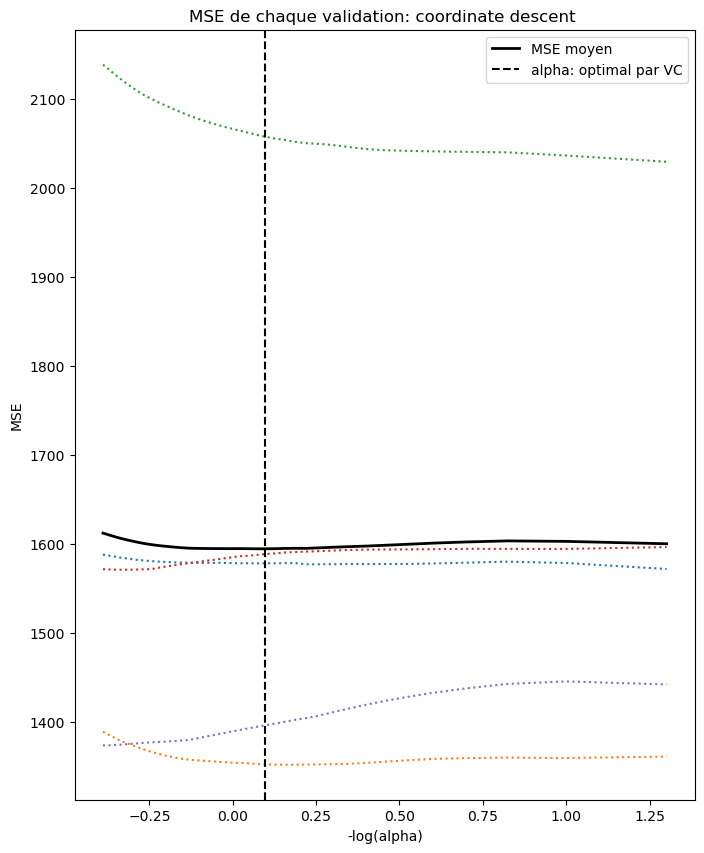

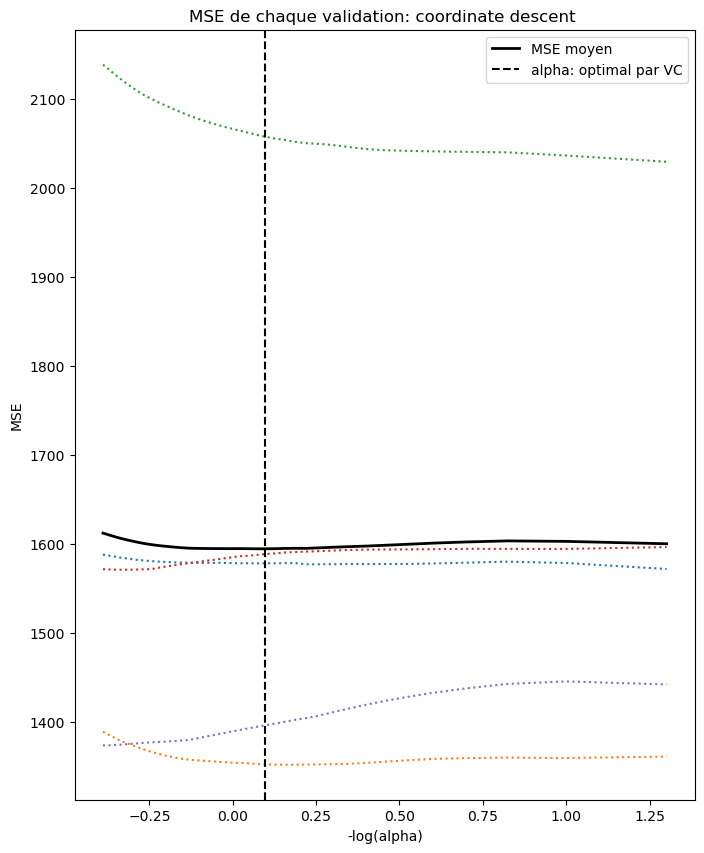

In [17]:
from sklearn.linear_model import LassoCV, LassoLarsCV
model = LassoCV(cv=5, alphas=np.array(range(1,50,1))/20.,n_jobs=-1,random_state=13).fit(XC_train,YC_train)
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
# ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='MSE moyen', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: optimal par VC')

plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('MSE')
plt.title('MSE de chaque validation: coordinate descent ')
plt.show()

####################################################################
#Algo LassoLarCV --> pas de grands changements 
alphas = np.array(range(1, 50)) / 20.  # De 0.05 à 2.45

model2 = LassoCV(alphas=alphas, cv=5, n_jobs=-1, random_state=13).fit(XC_train, YC_train)
m_log_alphas2 = -np.log10(model2.alphas_)
plt.figure()
# ymin, ymax = 2300, 3800
plt.plot(m_log_alphas2, model2.mse_path_, ':')
plt.plot(m_log_alphas2, model2.mse_path_.mean(axis=-1), 'k',
         label='MSE moyen', linewidth=2)
plt.axvline(-np.log10(model2.alpha_), linestyle='--', color='k',
            label='alpha: optimal par VC')

plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('MSE')
plt.title('MSE de chaque validation: coordinate descent ')
plt.show()

On retrouve le $\alpha=0.13$ environ. On prend maintenant cette valeur pour $\alpha$ et on va faire de la sélection de variables. 

In [18]:
# Pour tout le jeu de données
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.13)
lasso.fit(XC_train, YC_train)

# Récupère les noms des variables retenues (coefficients ≠ 0)
coef = lasso.coef_
selected_features = [name for name, c in zip(dfC.columns, coef) if c != 0]

print("Variables retenues :", selected_features)
dfC_selected = dfC[selected_features]

#On renormalise nos données 
scaler = StandardScaler()
X_selected = dfC[selected_features]
X_train_sel, X_test_sel = train_test_split(X_selected, test_size=0.2, random_state=11)
XC_train_sel = scaler.fit_transform(X_train_sel)
XC_test_sel = scaler.transform(X_test_sel)


Variables retenues : ['Gender_Female', 'Gender_Male', 'Workout_Type_Cardio', 'Workout_Type_HIIT', 'Workout_Type_Yoga', 'Workout_Frequency (days/week)_3', 'Workout_Frequency (days/week)_4', 'Workout_Frequency (days/week)_5', 'Experience_Level_2', 'Experience_Level_3', 'Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage', 'BMI']


In [19]:

regLassOpt_sel=regLasso.fit(XC_train_sel, YC_train)
# paramètre optimal
regLassOpt_sel.best_params_["alpha"]
print("Meilleur R2 = %f, Meilleur paramètre = %s" % (regLassOpt.best_score_,regLassOpt.best_params_))
prev_sel=regLassOpt_sel.predict(XC_test_sel)
print("MSE=",mean_squared_error(prev_sel,YC_test))
print("R2=",r2_score(YC_test,prev_sel))   

Meilleur R2 = 0.977498, Meilleur paramètre = {'alpha': 1.3}
MSE= 1586.9252006853244
R2= 0.9813603984854153


In [20]:
#Modèle sans sélection 
print("MSE=",mean_squared_error(prev,YC_test))
print("R2=",r2_score(YC_test,prev))  #très bonne corrélation 


MSE= 1587.4968465791533
R2= 0.9813536840847216


On va tracer les chemins de regularisation. 

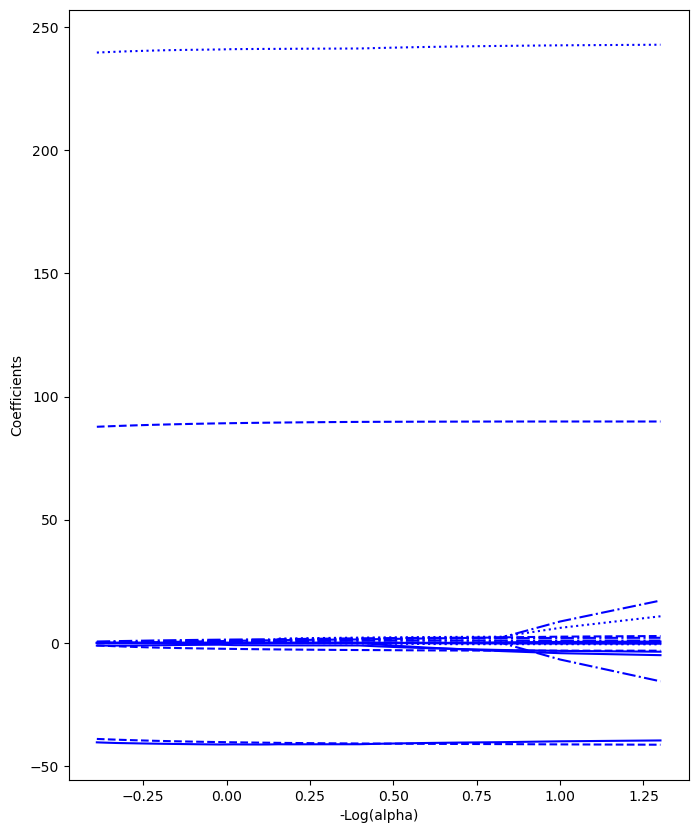

In [21]:
from itertools import cycle
# print(type(YC_train))
# print(np.shape(XC_train),np.shape(YC_train))
from sklearn.linear_model import lasso_path
alphas_lasso, coefs_lasso, _ = lasso_path(XC_train,YC_train, alphas=np.array(range(1,50,1))/20.,)

plt.figure()
ax = plt.gca()

styles = cycle(['-', '--', '-.', ':'])

neg_log_alphas_lasso = -np.log10(alphas_lasso)
# print(np.shape(neg_log_alphas_lasso ))
# print(np.shape(coefs_lasso))
# print(np.shape(alphas_lasso))
for coef_l, s in zip(coefs_lasso, styles):
    
   
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, linestyle=s,c='b')
plt.xlabel('-Log(alpha)')
plt.ylabel('Coefficients')
plt.show()

## 2. kNN et SVR

## 2.1 kNN : Classification (à voir si on garde)


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
#Variables explicatives
################Variables qualitatives
dataDum=pd.get_dummies(data[["Gender","Workout_Type","Workout_Frequency (days/week)","Experience_Level"]]) 
# pour transformer des variables qualitatives en variables indicatrices, 
# chaque valeur unique de la variable qualitative devient une colonne distincte dans le DataFrame résultant

################Variables quantitatives
dataQuant=data[["Age","Weight (kg)","Height (m)","Max_BPM","Avg_BPM","Resting_BPM","Session_Duration (hours)","Fat_Percentage","Water_Intake (liters)","BMI"]] 

# Concaténation des variables explicatives

dfC=pd.concat([dataDum,dataQuant],axis=1)
#print(type(dfC))

YC = data['Calories_Burned']
dfC_Classi=dfC.copy()
dfC_Classi['Calories_Category'] = pd.qcut(YC, q=3, labels=['Low', 'Medium', 'High']) # Transformation de "Calories_Burned" en 3 catégories
# Encoder la variable cible
le = LabelEncoder()
dfC_Classi['Calories_Category'] = le.fit_transform(dfC_Classi['Calories_Category'])
# Préparation des données pour la classification
X = dfC_Classi.drop(columns=['Calories_Category'])  # exclure la cible
y = dfC_Classi['Calories_Category']  # cible


# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Optimisation du paramètre k
param_grid = [{"n_neighbors": list(range(1, 15))}]
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)
knnOpt = knn.fit(X_train, y_train)

# Paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1 - knnOpt.best_score_, knnOpt.best_params_))

Meilleur score = 0.340596, Meilleur paramètre = {'n_neighbors': 14}


In [23]:
# Estimation de l'erreur de prévision sur l'échantillon test
1-knnOpt.score(X_train, y_train)

0.2956298200514139

In [24]:
# Prévision de l'échantillon test
y_chap = knnOpt.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_chap,y_test)
print(table)

Calories_Category   0   1   2
row_0                        
0                  46   1   6
1                   7  53  24
2                  16   9  33


# 2.2 : kNN régression.

| Paramètre       | Type / Valeurs possibles                    | Description                                                              |
| --------------- | ------------------------------------------- | ------------------------------------------------------------------------ |
| `n_neighbors`   | `int` (ex: `1` à `30`)                      | Nombre de voisins à prendre en compte                                    |
| `weights`       | `['uniform', 'distance']`                   | Poids accordés aux voisins (égaux ou proportionnels à la distance)       |
| `algorithm`     | `['auto', 'ball_tree', 'kd_tree', 'brute']` | Algorithme pour la recherche des plus proches voisins                    |
| `leaf_size`     | `int` (ex: `10` à `100`)                    | Paramètre utilisé dans `kd_tree` ou `ball_tree`                          |
| `p`             | `1` ou `2`                                  | Paramètre de la distance de Minkowski : `1 = manhattan`, `2 = euclidean` |
| `metric`        | `['minkowski', 'euclidean', 'manhattan']`   | Type de distance utilisée                                                |
| `metric_params` | `dict`                                      | Paramètres supplémentaires pour la métrique (rarement utilisé)           |
| `n_jobs`        | `-1` ou `int`                               | Nombre de cœurs utilisés (utile en GridSearch)                           |


In [25]:
from sklearn.neighbors import KNeighborsRegressor

# Optimisation de k (nombre de voisins)
param_grid = {
    'n_neighbors': [3, 5, 10,12,15,18],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': [10,20, 30, 40]
}
knn_reg = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, n_jobs=-1)
knnOpt = knn_reg.fit(XC_train, YC_train)

# Meilleur paramètre
print("Meilleur score (cross-val MSE) = %f, Meilleur paramètre = %s" % (1 - knnOpt.best_score_, knnOpt.best_params_))

Meilleur score (cross-val MSE) = 0.318520, Meilleur paramètre = {'leaf_size': 10, 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}


MSE sur l'échantillon test : 21001.62
R2= 0.7533205320119392


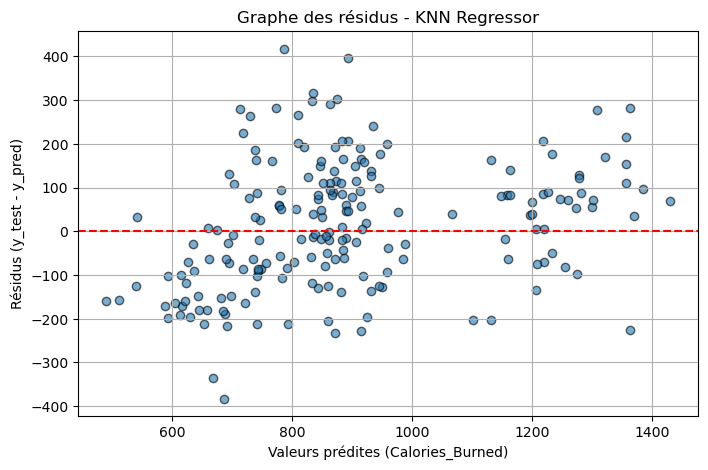

In [26]:
# Prédictions sur l’échantillon test
prev_kNN = knnOpt.predict(XC_test)

# Calcul du MSE sur test
mse_kNN = mean_squared_error(YC_test, prev_kNN)
print("MSE sur l'échantillon test : %.2f" % mse_kNN) #gros MSE ? 
print("R2=",r2_score(YC_test,prev_kNN)) 
# Tracé des résidus
residus_kNN = YC_test - prev_kNN
plt.figure(figsize=(8, 5))
plt.scatter(prev_kNN, residus_kNN, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites (Calories_Burned)')
plt.ylabel('Résidus (y_test - y_pred)')
plt.title('Graphe des résidus - KNN Regressor')
plt.grid(True)
plt.show()

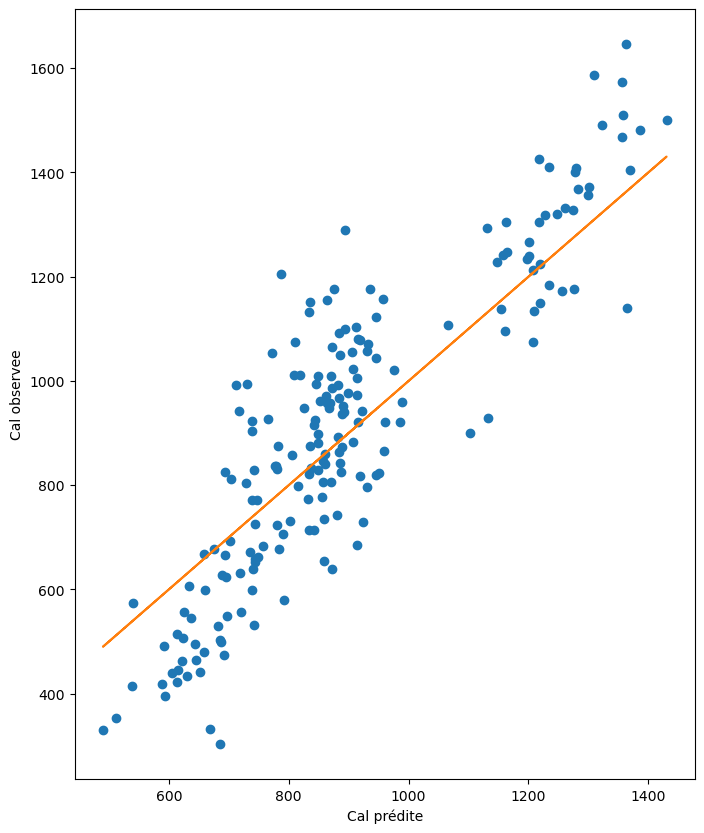

In [27]:
#Valeurs prédites contre les valeurs observées 
plt.plot(prev_kNN,YC_test,"o")
plt.plot(prev_kNN,prev_kNN)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.show()


On va tester avec notre sélection de variables. 

In [28]:
# Optimisation de k (nombre de voisins)
knnOpt_sel = knn_reg.fit(XC_train_sel, YC_train)

# Meilleur paramètre
print("Meilleur score (cross-val MSE) = %f, Meilleur paramètre = %s" % (1 - knnOpt_sel.best_score_, knnOpt_sel.best_params_))

Meilleur score (cross-val MSE) = 0.266905, Meilleur paramètre = {'leaf_size': 10, 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}


MSE sur l'échantillon test : 17000.29
R2= 0.8003191518774069


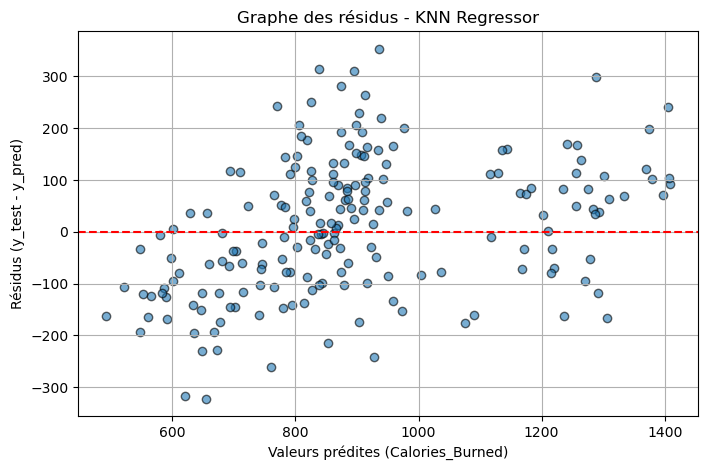

In [29]:
# Prédictions sur l’échantillon test
prev_kNN_sel = knnOpt.predict(XC_test_sel)

# Calcul du MSE sur test
mse_kNN_sel = mean_squared_error(YC_test, prev_kNN_sel)
print("MSE sur l'échantillon test : %.2f" % mse_kNN_sel) 
# MSE plus basse avec sélection de variable mais tjr haut par rapport aux autres méthodes 
print("R2=",r2_score(YC_test,prev_kNN_sel)) 
# Tracé des résidus
residus_kNN_sel = YC_test - prev_kNN_sel
plt.figure(figsize=(8, 5))
plt.scatter(prev_kNN_sel, residus_kNN_sel, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites (Calories_Burned)')
plt.ylabel('Résidus (y_test - y_pred)')
plt.title('Graphe des résidus - KNN Regressor')
plt.grid(True)
plt.show()

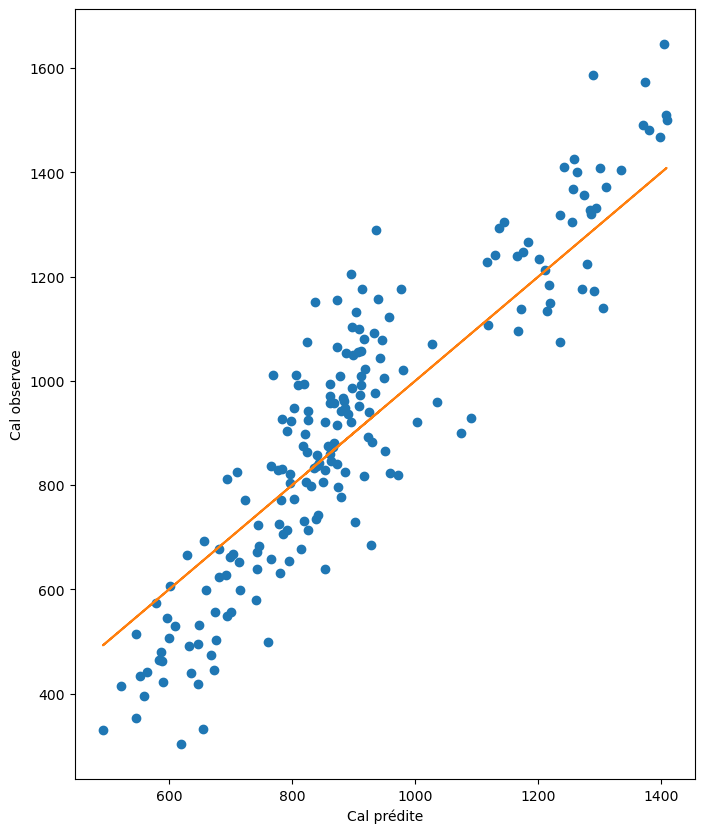

In [30]:
#Valeurs prédites contre les valeurs observées 
plt.plot(prev_kNN_sel,YC_test,"o")
plt.plot(prev_kNN_sel,prev_kNN_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.show()


## 2.2 SVR

Hyperparamètres possibles à optimiser : 
| Paramètre   | Valeurs typiques à tester                | Rôle                                                                                                                    |
| ----------- | ---------------------------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| `C`         | `[0.01, 0.1, 1, 10, 100]`                | Contrôle la **pénalité** sur les erreurs : un **C élevé** => moins de tolérance à l’erreur, risque de surapprentissage. |
| `epsilon`   | `[0.001, 0.01, 0.1, 1]`                  | Définie la **zone autour de la prédiction** dans laquelle aucune pénalité n'est appliquée (le “tube ε-insensitive”).    |
| `kernel`    | `["linear", "poly", "rbf", "sigmoid"]`   | Noyau utilisé pour la projection des données. `rbf` est souvent un bon choix par défaut.                                |
| `gamma`     | `["scale", "auto", 0.001, 0.01, 0.1, 1]` | Utilisé avec les noyaux non linéaires. Contrôle l’influence d’un seul point d’entraînement.                             |
| `degree`    | `[2, 3, 4, 5]` *(si kernel='poly')*      | Degré du polynôme pour le noyau polynomial.                                                                             |
| `shrinking` | `[True, False]`                          | Active ou non l’heuristique de **réduction du vecteur de support**.                                                     |
| `tol`       | `[1e-3, 1e-4]`                           | Critère de **tolérance** d’arrêt.                                                                                       |


Le paramètre C contrôle le compromis entre biais et variance :

    Petit C → le modèle accepte plus d'erreur à l'intérieur du tube ε, ce qui donne une solution plus lisse (plus de biais, moins de variance).

    Grand C → le modèle pénalise fortement les erreurs, cherchant à prédire le plus proche possible des vraies valeurs (moins de biais, mais plus de variance).

In [31]:
from sklearn.svm import SVR
#Au cas où, important pour cette méthode
scaler = StandardScaler()
XC_train = scaler.fit_transform(X_train)
XC_test = scaler.transform(X_test)
#optimisation des autres paramètres 
param_grid = { 
    "C": [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 1,2],
    "kernel": ["rbf"],
    "gamma": ["scale", "auto"]
}

svr = GridSearchCV(SVR(), param_grid, cv=5, n_jobs=-1)
svrOpt = svr.fit(XC_train, YC_train)
print("Sans SV, Meilleur score = %f, Meilleur paramètre = %s" % (1. - svrOpt.best_score_, svrOpt.best_params_))


Sans SV, Meilleur score = 0.045864, Meilleur paramètre = {'C': 100, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}


In [32]:
# erreur de régression sur le test
1-svrOpt.score(XC_test,YC_test)

0.025466773148531074

Sans SV, MSE sur l'échantillon test (SVR) : 2168.17
Sans SV, R2= 0.9745332268514689


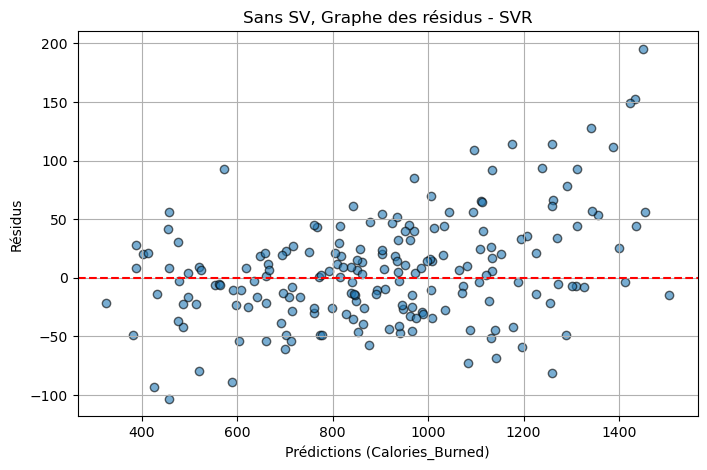

In [33]:
# Prédictions sur le jeu de test
pred_svr = svrOpt.predict(XC_test)
# Calcul des résidus
residus_svr = YC_test - pred_svr
# Calcul du MSE
mse_svr = mean_squared_error(YC_test, pred_svr)
print("Sans SV, MSE sur l'échantillon test (SVR) : %.2f" % mse_svr)
print("Sans SV, R2=",r2_score(YC_test,pred_svr)) 
# Tracé des résidus
plt.figure(figsize=(8, 5))
plt.scatter(pred_svr, residus_svr, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions (Calories_Burned)')
plt.ylabel('Résidus')
plt.title('Sans SV, Graphe des résidus - SVR')
plt.grid(True)
plt.show()


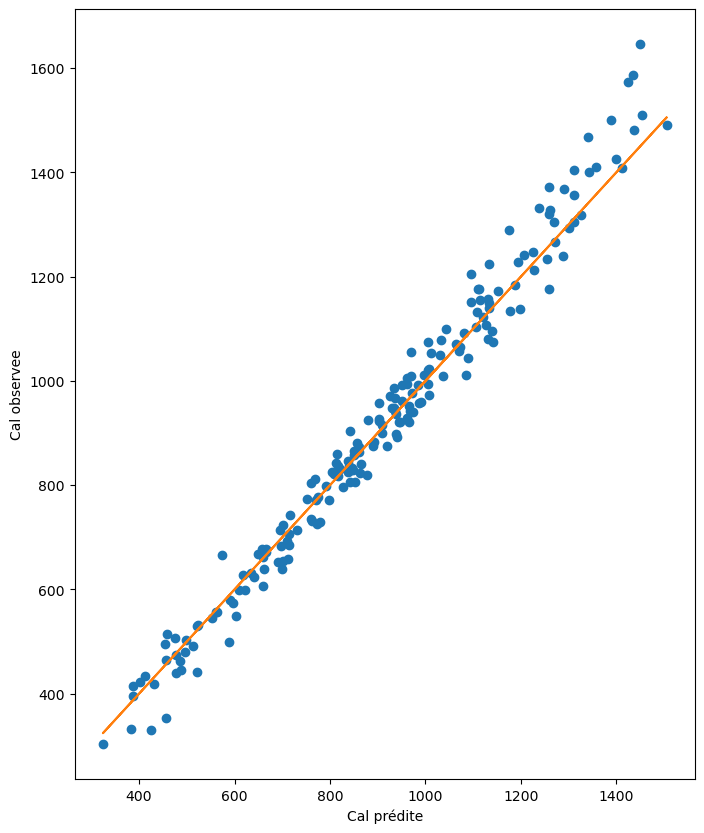

In [34]:
plt.plot(pred_svr,YC_test,"o")
plt.plot(pred_svr,pred_svr)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.show()

In [35]:
svrOpt_sel=svr.fit(XC_train_sel,YC_train)
print("Avec SV, Meilleur score = %f, Meilleur paramètre = %s" % (1. - svrOpt_sel.best_score_, svrOpt_sel.best_params_))

Avec SV, Meilleur score = 0.046894, Meilleur paramètre = {'C': 100, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}


In [36]:
# erreur de régression sur le test
1-svrOpt_sel.score(XC_test_sel,YC_test)

0.027548021598736483

Avec SV, MSE sur l'échantillon test (SVR) : 2345.36
Avec SV, R2= 0.9724519784012635


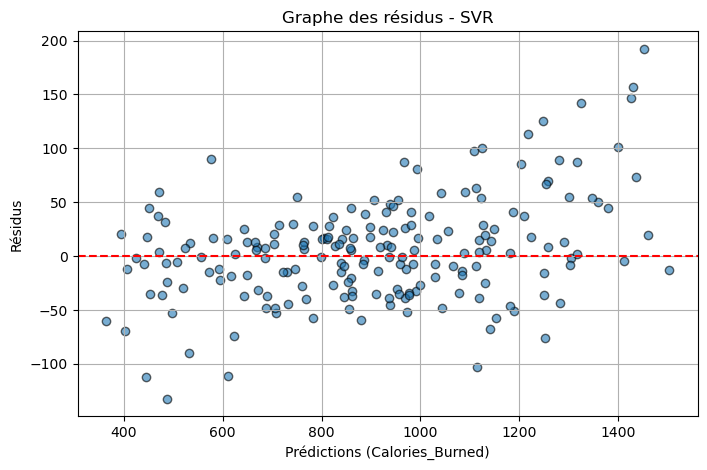

In [37]:
# Prédictions sur le jeu de test
pred_svr_sel = svrOpt_sel.predict(XC_test_sel)

# Calcul des résidus
residus_svr_sel = YC_test - pred_svr_sel

# Calcul du MSE
mse_svr_sel = mean_squared_error(YC_test, pred_svr_sel)
print("Avec SV, MSE sur l'échantillon test (SVR) : %.2f" % mse_svr_sel)
print("Avec SV, R2=",r2_score(YC_test,pred_svr_sel)) 
# Tracé des résidus
plt.figure(figsize=(8, 5))
plt.scatter(pred_svr_sel, residus_svr_sel, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions (Calories_Burned)')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - SVR')
plt.grid(True)
plt.show()

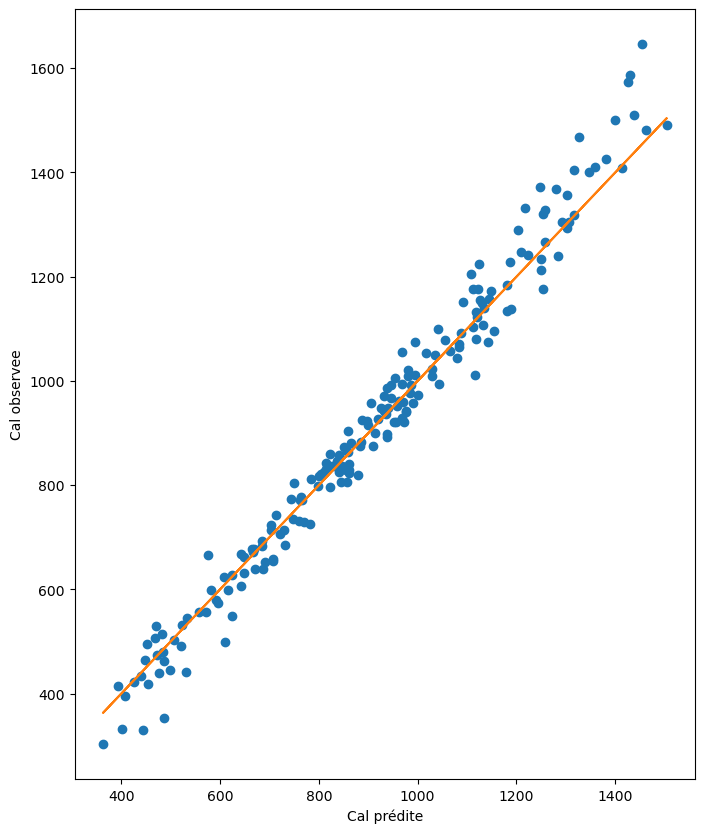

In [38]:
plt.plot(pred_svr_sel,YC_test,"o")
plt.plot(pred_svr_sel,pred_svr_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.show()

# Arbre de régression 

In [39]:
from sklearn.tree import DecisionTreeRegressor

# Optimisation de la profondeur de l'arbre
param = [{"max_depth": list(range(2, 10))}]
tree = GridSearchCV(DecisionTreeRegressor(), param, cv=10, n_jobs=-1)
treeOpt = tree.fit(XC_train, YC_train)

# Affichage du meilleur paramètre
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_, treeOpt.best_params_))
# Prédictions sur le jeu de test
y_pred_tree = treeOpt.predict(XC_test)

# Calcul des résidus
residus_tree = YC_test - y_pred_tree

# MSE
mse_tree = mean_squared_error(YC_test, y_pred_tree)
print("MSE sur l'échantillon test (arbre de régression) : %.2f" % mse_tree)
print("R2=",r2_score(YC_test,y_pred_tree)) 


Meilleur score = 0.078293, Meilleur paramètre = {'max_depth': 9}
MSE sur l'échantillon test (arbre de régression) : 5512.65
R2= 0.9352498218800136


MSE sur l'échantillon test : 5512.6548
R2= 0.9352498218800136


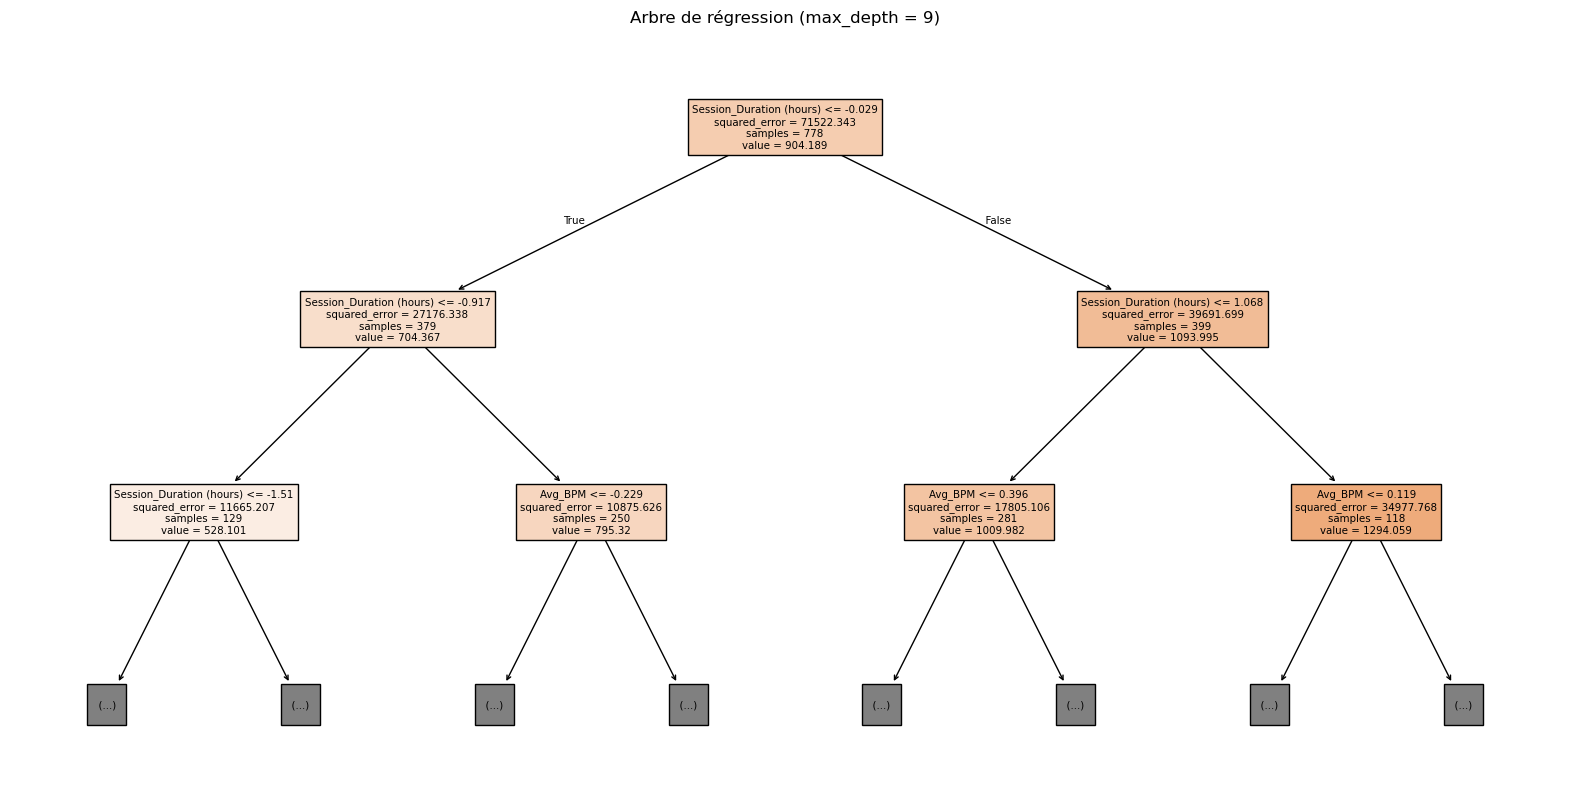

In [40]:

from sklearn.tree import DecisionTreeRegressor, plot_tree
# Ré-entraînement de l'arbre avec la profondeur optimale trouvée
treeG = DecisionTreeRegressor(max_depth=treeOpt.best_params_['max_depth'])
treeG.fit(XC_train, YC_train)

# Calcul du MSE
mse = mean_squared_error(YC_test, y_pred_tree)
print(f"MSE sur l'échantillon test : {mse:.4f}")
print("R2=",r2_score(YC_test,y_pred_tree)) 
# Tracé de l'arbre
plt.figure(figsize=(20, 10))  # Ajuste la taille pour la lisibilité
plot_tree(treeG, feature_names=dfC.columns.tolist(), filled=True, max_depth=2)
plt.title("Arbre de régression (max_depth = %d)" % treeOpt.best_params_['max_depth'])
plt.show()


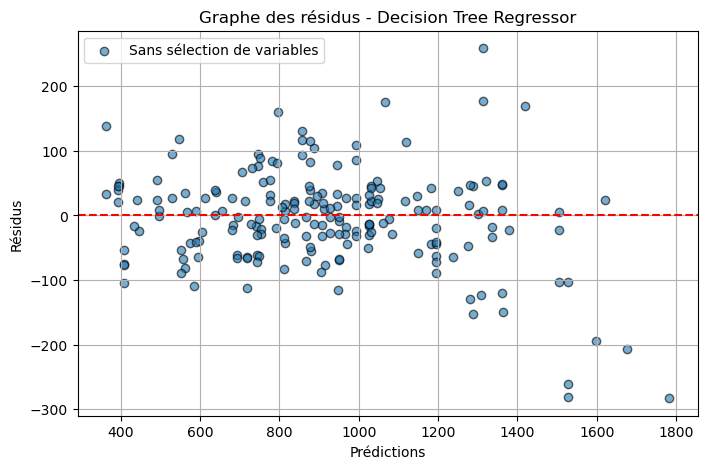

In [41]:

# Prédictions sur l'échantillon test
y_pred = treeG.predict(XC_test)

# Calcul des résidus
residus = YC_test - y_pred

# Tracé des résidus
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residus, alpha=0.6, edgecolors='k',label="Sans sélection de variables")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.legend()
plt.title('Graphe des résidus - Decision Tree Regressor')
plt.grid(True)
plt.show()

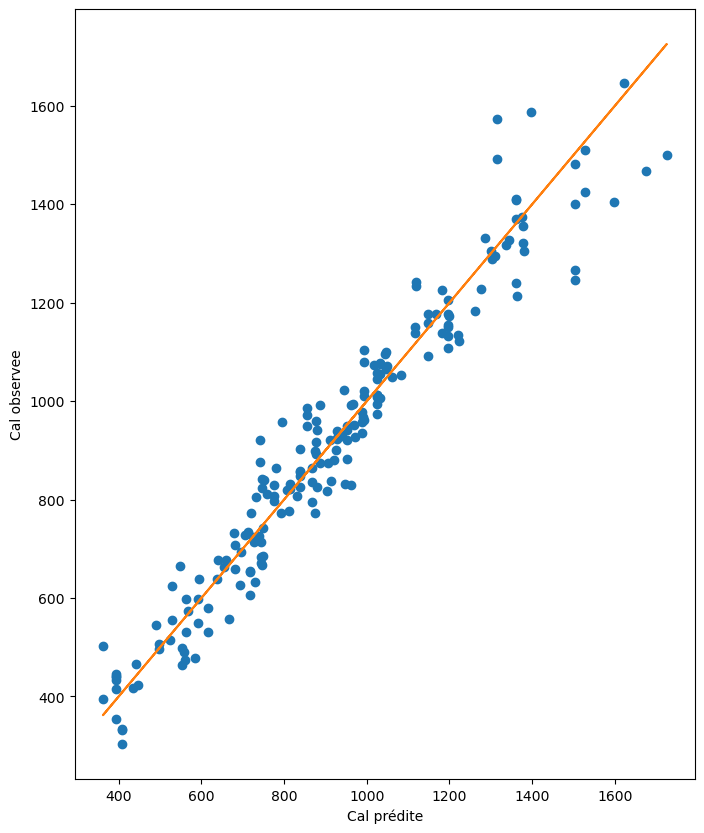

In [42]:
plt.plot(y_pred_tree,YC_test,"o")
plt.plot(y_pred_tree,y_pred_tree)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.show()

Cas avec sélection de variables

In [43]:
treeOpt_sel = tree.fit(XC_train_sel, YC_train)

# Affichage du meilleur paramètre
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt_sel.best_score_, treeOpt_sel.best_params_))
# Prédictions sur le jeu de test
y_pred_tree_sel = treeOpt.predict(XC_test_sel)

# MSE
mse_tree_sel = mean_squared_error(YC_test, y_pred_tree_sel)
print("MSE sur l'échantillon test (arbre de régression) : %.2f" % mse_tree_sel)
print("R2=",r2_score(YC_test,y_pred_tree_sel)) 

Meilleur score = 0.081334, Meilleur paramètre = {'max_depth': 9}
MSE sur l'échantillon test (arbre de régression) : 5439.67
R2= 0.9361071325318053


MSE sur l'échantillon test : 5439.6657
R2= 0.9352498218800136


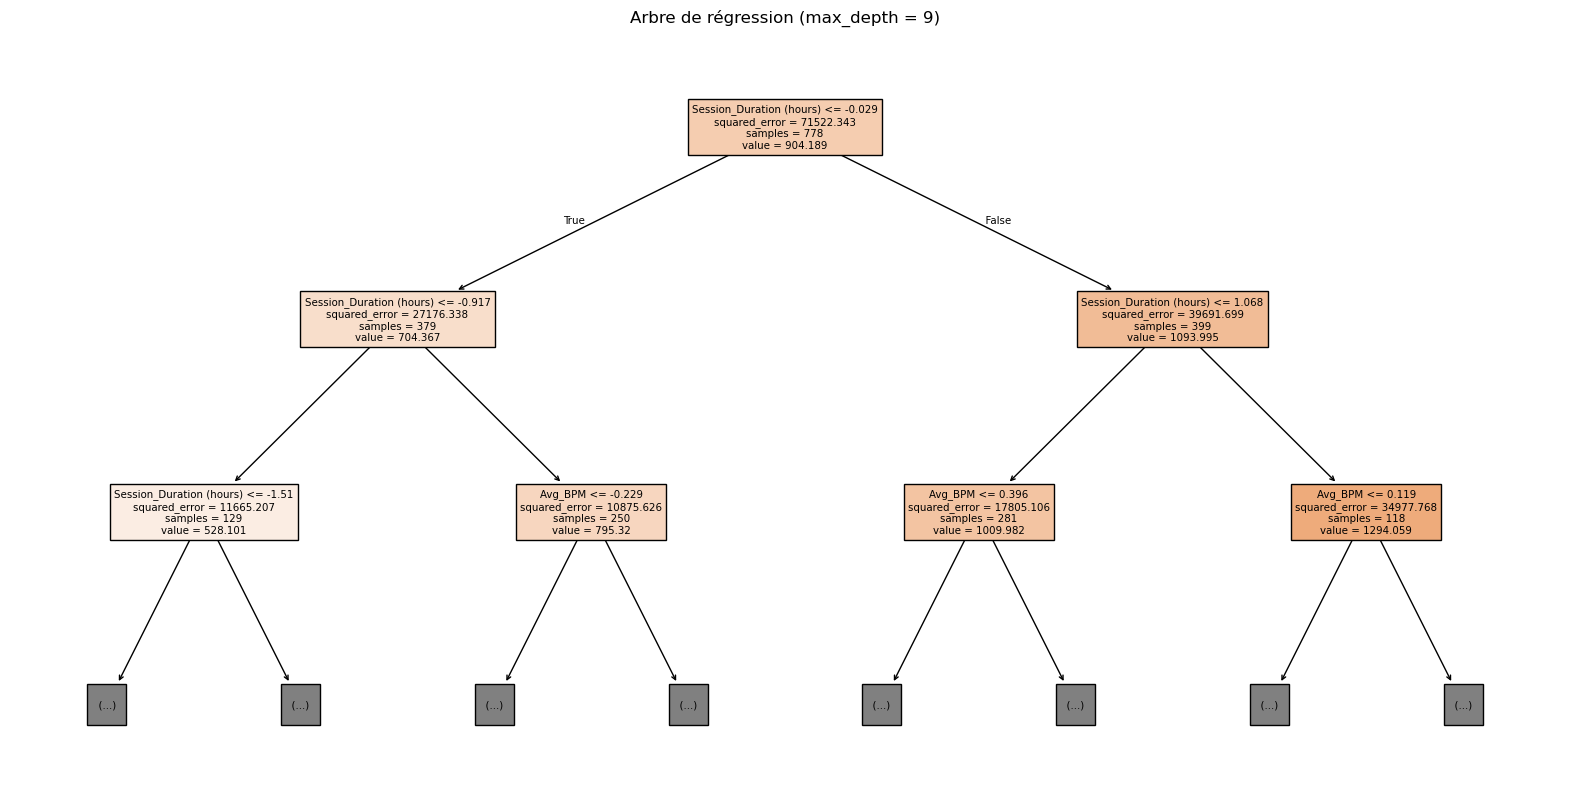

In [44]:

# Ré-entraînement de l'arbre avec la profondeur optimale trouvée
treeG_sel = DecisionTreeRegressor(max_depth=treeOpt_sel.best_params_['max_depth'])
treeG_sel.fit(XC_train_sel, YC_train)

# rappels perfs
print(f"MSE sur l'échantillon test : {mse_tree_sel:.4f}")
print("R2=",r2_score(YC_test,y_pred_tree)) 
# Tracé de l'arbre
plt.figure(figsize=(20, 10))  # Ajuste la taille pour la lisibilité
plot_tree(treeG, feature_names=dfC.columns.tolist(), filled=True, max_depth=2)
plt.title("Arbre de régression (max_depth = %d)" % treeOpt.best_params_['max_depth'])
plt.show()

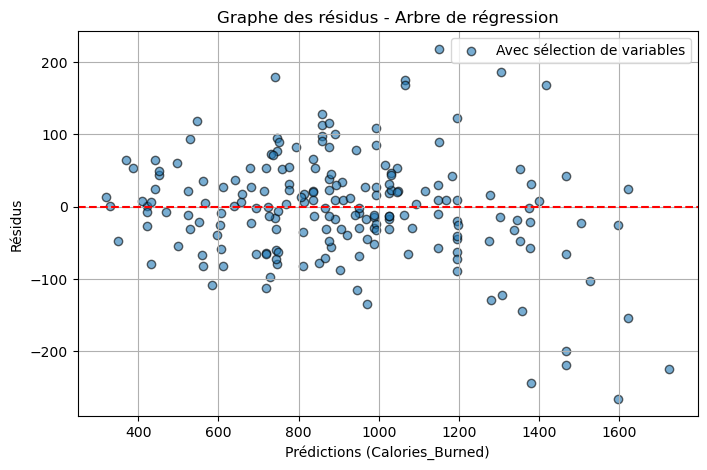

In [45]:
# Tracé des résidus

# Calcul des résidus
residus_tree_sel = YC_test - y_pred_tree_sel
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_tree_sel, residus_tree_sel, alpha=0.6, edgecolors='k',label="Avec sélection de variables")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions (Calories_Burned)')
plt.legend()
plt.ylabel('Résidus')
plt.title('Graphe des résidus - Arbre de régression')
plt.grid(True)
plt.show()

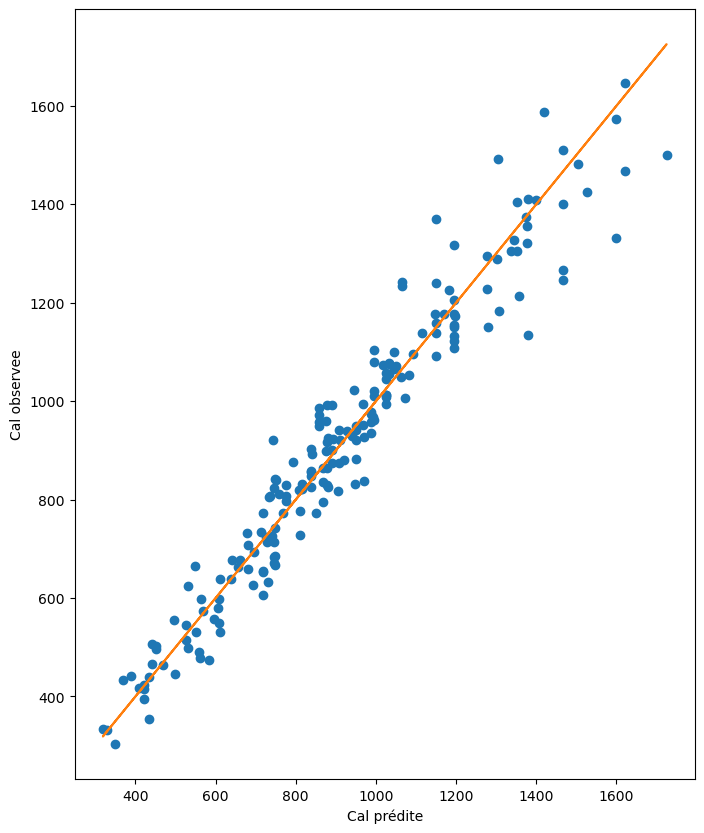

In [46]:
plt.plot(y_pred_tree_sel,YC_test,"o")
plt.plot(y_pred_tree_sel,y_pred_tree_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.show()

# 4 Forêt aléatoire 

Meilleur score = 0.031537, Meilleur paramètre = {'max_features': 20}
Erreur OOB (MSE approximatif) = N/A
MSE sur échantillon test = 1731.0858
Sans SV, R2= 0.9796671263454838


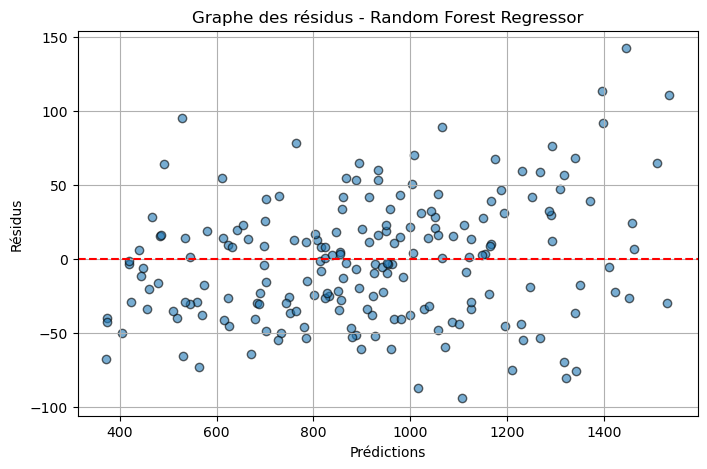

In [47]:
from sklearn.ensemble import RandomForestRegressor

param = [{"max_features": list(range(5, 22))}]
rf = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=42),
                  param, cv=5, n_jobs=-1)
rfOpt = rf.fit(XC_train, YC_train)

print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_, rfOpt.best_params_))

# Affichage de l'erreur OOB (out-of-bag error)
print(f"Erreur OOB (MSE approximatif) = {1 - rfOpt.oob_score_ if hasattr(rfOpt, 'oob_score_') else 'N/A'}")

# Prédiction sur l'échantillon test
pred_Rtree = rfOpt.predict(XC_test)

# Calcul du MSE sur l'échantillon test
mse = mean_squared_error(YC_test, pred_Rtree)
print(f"MSE sur échantillon test = {mse:.4f}")
print("Sans SV, R2=",r2_score(YC_test,pred_Rtree)) 
# Tracé des résidus
residus_Rtree = YC_test - pred_Rtree
plt.figure(figsize=(8,5))
plt.scatter(pred_Rtree, residus_Rtree, alpha=0.6, edgecolors='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Graphe des résidus - Random Forest Regressor')
plt.grid(True)
plt.show()

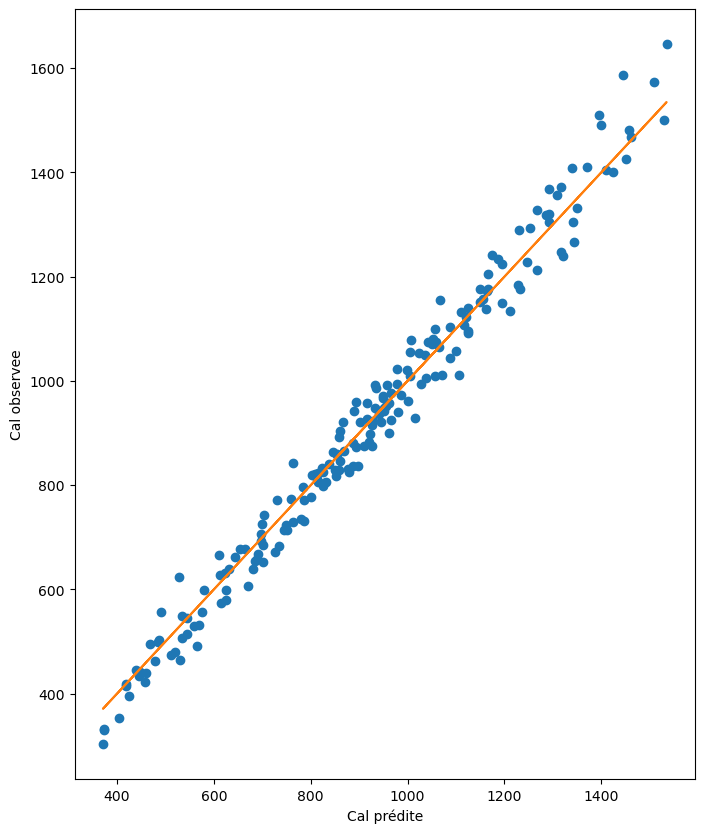

In [48]:
plt.plot(pred_Rtree,YC_test,"o")
plt.plot(pred_Rtree,pred_Rtree)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.show()

In [49]:
# erreur de prévision sur le test
1-rfOpt.score(XC_test,YC_test)

0.020332873654516193

In [50]:
rf = RandomForestRegressor(n_estimators=100, max_features=2, random_state=42)
rfFit = rf.fit(XC_train, YC_train)

# Importance décroissante des variables
importances = rfFit.feature_importances_
indices = np.argsort(importances)[::-1]
# on affiche l'importance par variables
i=1
for f in range(XC_train.shape[1]):
    print(i,dfC.columns[indices[f]], importances[indices[f]])
    i=i+1

1 Session_Duration (hours) 0.25350385292000105
2 Fat_Percentage 0.14017786104052354
3 Experience_Level_3 0.08610724857381806
4 Avg_BPM 0.07481173291622642
5 Experience_Level_1 0.06224882446553932
6 Water_Intake (liters) 0.04799797694094496
7 Weight (kg) 0.047633836938883956
8 Age 0.038272068651661176
9 BMI 0.033662832201778584
10 Height (m) 0.03214236781966954
11 Max_BPM 0.028817535355538083
12 Resting_BPM 0.02790341702324843
13 Experience_Level_2 0.026851096609498623
14 Workout_Frequency (days/week)_5 0.026382271413777584
15 Workout_Frequency (days/week)_2 0.014260454660466831
16 Workout_Frequency (days/week)_3 0.013017648670870867
17 Workout_Frequency (days/week)_4 0.009799144430793492
18 Gender_Male 0.008454605012830865
19 Gender_Female 0.00668698177097331
20 Workout_Type_Strength 0.006062192619902468
21 Workout_Type_Cardio 0.005540661528943578
22 Workout_Type_HIIT 0.005323894635494616
23 Workout_Type_Yoga 0.004341493798614637


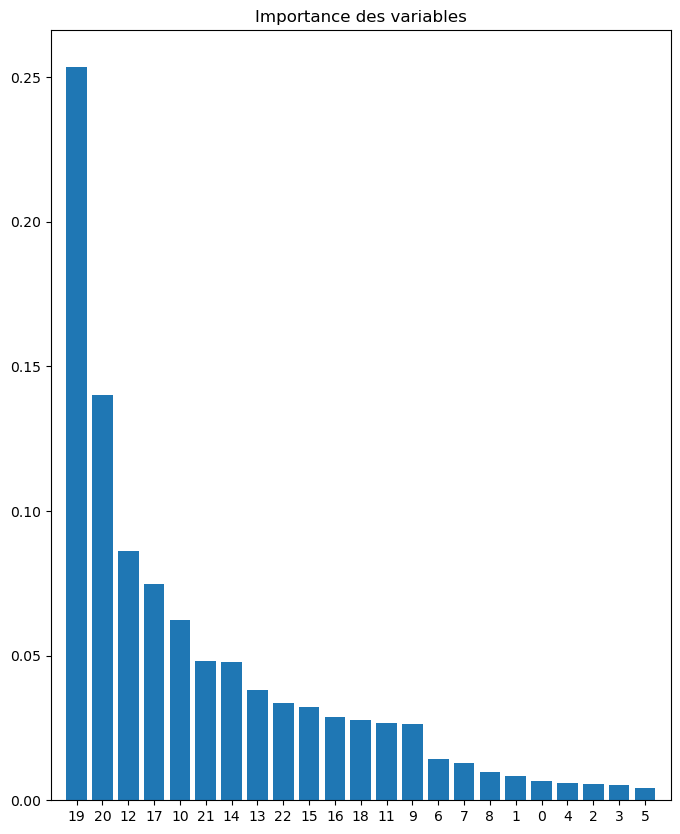

In [51]:
# Graphe des importances
plt.figure()
plt.title("Importance des variables")
plt.bar(range(XC_train.shape[1]), importances[indices])
plt.xticks(range(XC_train.shape[1]), indices)
plt.xlim([-1, XC_train.shape[1]])
plt.show()

# 5 Réseaux de Neuronnes

| Paramètre            | Type / Valeurs possibles                        | Rôle                                                             |
| -------------------- | ----------------------------------------------- | ---------------------------------------------------------------- |
| `hidden_layer_sizes` | `[(50,), (100,), (50,50), (100,50), (100,100)]` | Architecture du réseau (nombres de neurones par couche cachée)   |
| `activation`         | `["identity", "logistic", "tanh", "relu"]`      | Fonction d'activation dans les couches cachées                   |
| `solver`             | `["lbfgs", "sgd", "adam"]`                      | Algorithme d’optimisation                                        |
| `alpha`              | `[0.0001, 0.001, 0.01, 0.1, 1]`                 | Terme de régularisation L2                                       |
| `batch_size`         | `["auto", 16, 32, 64, 128]`                     | Taille des mini-lots pour SGD ou adam                            |
| `learning_rate`      | `["constant", "invscaling", "adaptive"]`        | Stratégie d’adaptation du taux d’apprentissage                   |
| `learning_rate_init` | `[0.001, 0.01, 0.1]`                            | Taux d’apprentissage initial                                     |
| `max_iter`           | `[200, 300, 500, 1000]`                         | Nombre maximal d’itérations                                      |
| `early_stopping`     | `[True, False]`                                 | Active un arrêt automatique si la validation ne s'améliore plus  |
| `tol`                | `[1e-4, 1e-3]`                                  | Tolérance pour l’arrêt de l’optimisation                         |
| `momentum`           | `[0.9, 0.95, 0.99]` (si `solver='sgd'`)         | Moment utilisé lors de l’optimisation par SGD                    |
| `n_iter_no_change`   | `[5, 10, 20]`                                   | Nombre d’itérations sans amélioration pour `early_stopping=True` |


In [52]:
from sklearn.neural_network import MLPRegressor

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Meilleur score = 0.981217
Meilleur paramètre = {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (150,), 'learning_rate_init': 0.01, 'solver': 'adam'}
MSE sur test = 1731.0858
R2= 0.985638667470102


c:\Users\edgar\anaconda3\envs\Keras_Env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


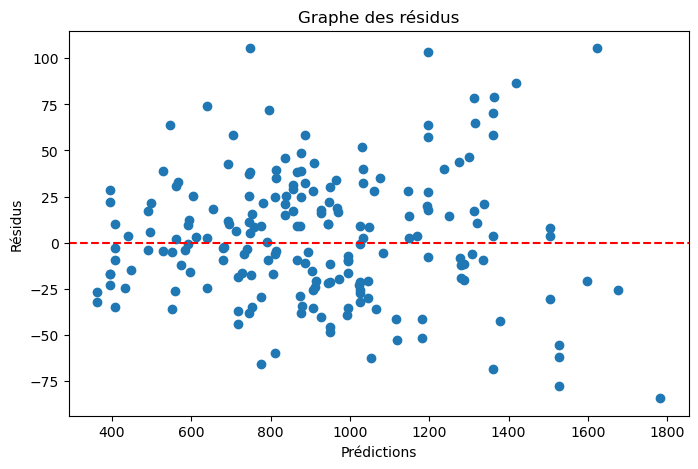

In [53]:
#Système de paramètres pour l'optimisation
param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (100, 50), (50, 25),(150,)], #opti (100,50)
    "activation": ["relu", "tanh"],
    "solver": ["adam", "lbfgs"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate_init": [0.001, 0.01],
}

mlp = MLPRegressor(max_iter=300, random_state=42) 

grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)#validation croisée pour trouver les paramètres opti
grid_search.fit(XC_train, YC_train)

print("Meilleur score = %f" % (grid_search.best_score_)) # score moyen obtenu en validation croisée 
print("Meilleur paramètre =", grid_search.best_params_)

# Évaluation sur test
best_model = grid_search.best_estimator_
pred_NN = best_model.predict(XC_test)
mse_NN = mean_squared_error(YC_test, pred_NN)
print(f"MSE sur test = {mse:.4f}")
print("R2=",r2_score(YC_test,pred_NN))   # R2 sur l'échantillon test 

residuals = YC_test - pred_NN
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Prédictions")
plt.ylabel("Résidus")
plt.title("Graphe des résidus")
plt.show()

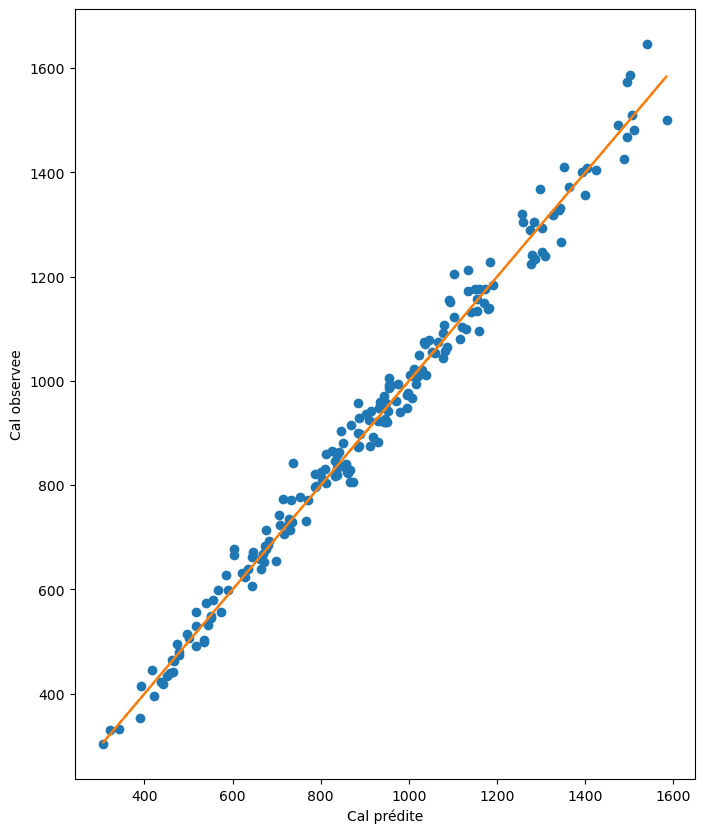

In [54]:
plt.plot(pred_NN,YC_test,"o")
plt.plot(pred_NN,pred_NN)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.show()

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Meilleur score = 0.981996
Meilleur paramètre = {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150,), 'learning_rate_init': 0.01, 'solver': 'adam'}
MSE sur test = 1219.3563
R2= 0.9856777652646878


c:\Users\edgar\anaconda3\envs\Keras_Env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


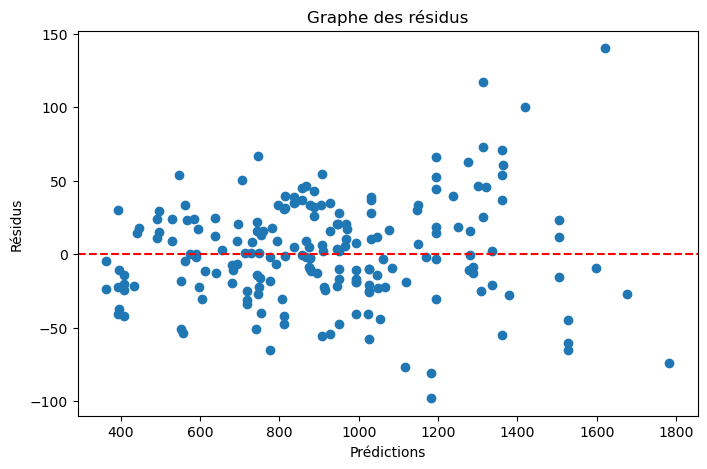

In [55]:
#Système de paramètres pour l'optimisation
mlp = MLPRegressor(max_iter=500, random_state=42) 

grid_search_sel = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)#validation croisée pour trouver les paramètres opti
grid_search_sel.fit(XC_train_sel, YC_train)

print("Meilleur score = %f" % (grid_search_sel.best_score_)) # score moyen obtenu en validation croisée 
print("Meilleur paramètre =", grid_search_sel.best_params_)

# Évaluation sur test
best_model_sel = grid_search_sel.best_estimator_
pred_NN_sel = best_model_sel.predict(XC_test_sel)
mse = mean_squared_error(YC_test, pred_NN_sel )
print(f"MSE sur test = {mse:.4f}")
print("R2=",r2_score(YC_test,pred_NN_sel ))   # R2 sur l'échantillon test 

residuals = YC_test - pred_NN_sel 
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Prédictions")
plt.ylabel("Résidus")
plt.title("Graphe des résidus")
plt.show()

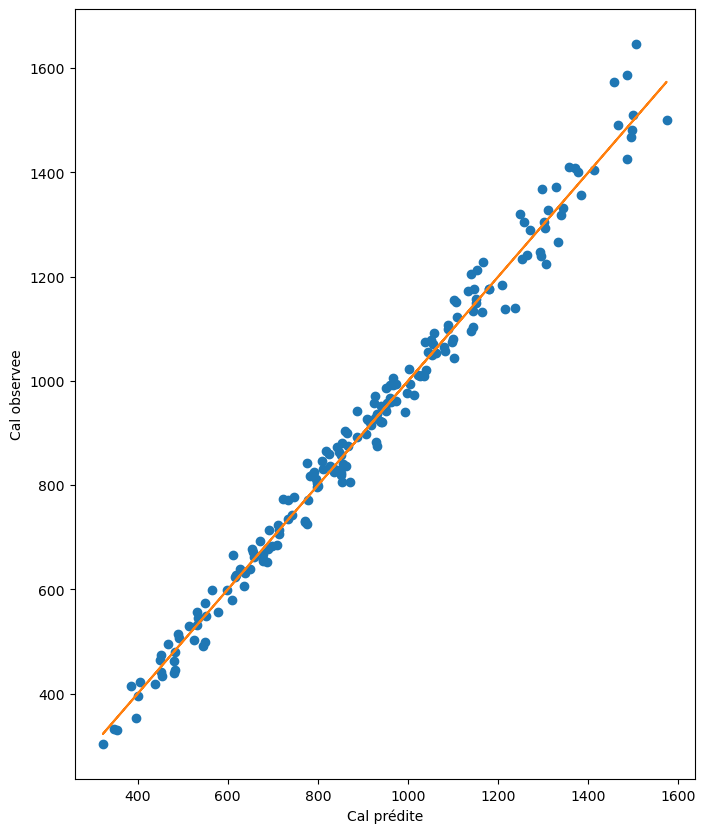

In [56]:
plt.plot(pred_NN_sel,YC_test,"o")
plt.plot(pred_NN_sel,pred_NN_sel)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.show()

# 6. Deep-learning et réseaux profonds 


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Définir la fonction de création du modèle
def build_model(n_hidden=1, n_neurons=32, learning_rate=0.01):
    model = Sequential()     #Modèle sequentielle : "empilement" linéaire 
    model.add(Dense(n_neurons, input_dim=XC_train.shape[1], activation='relu'))  
    # Couche d’entrée, recoit un vecteur de taille XC_train[1]
    # fonction d'activation 'relu', avec n_neurons
    for _ in range(n_hidden - 1):  # Couches cachées supplémentaires 
        model.add(Dense(n_neurons, activation='relu'))
    model.add(Dense(1))  # Couche de sortie avec 1 seul neurone car on veux prédire une seule variable continue
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Wrapping du modèle Keras pour GridSearchCV
model = KerasRegressor(build_fn=build_model, verbose=0)

# Grille des hyperparamètres à tester
param_grid = {
    'n_hidden': [1, 2],
    'n_neurons': [16, 32, 64,128],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [20,50,100,150]
}

# Recherche des meilleurs hyperparamètres
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(XC_train, YC_train)


C:\Users\edgar\AppData\Local\Temp\ipykernel_6812\4185928100.py:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, verbose=0)


Meilleur score (val. MSE) = 1180.8503
Meilleurs paramètres : {'batch_size': 32, 'epochs': 150, 'learning_rate': 0.01, 'n_hidden': 1, 'n_neurons': 128}
MSE sur test = 997.9597
R2= 0.9882782309796235


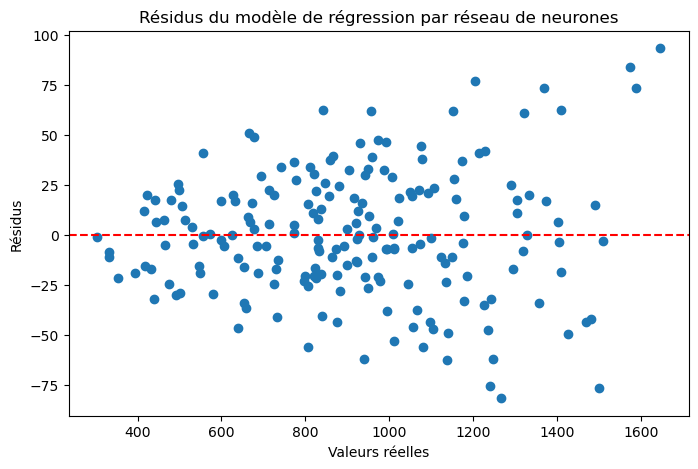

In [74]:
# Résultat optimal
print("Meilleur score (val. MSE) = %.4f" % abs(grid_result.best_score_))  # convention MSE négative en sortie de la cross-validation
print("Meilleurs paramètres :", grid_result.best_params_)

# Prédiction avec le meilleur modèle
best_model = grid_result.best_estimator_
pred_DNN = best_model.predict(XC_test)

# Calcul des résidus et du MSE
residuals_DNN = YC_test - pred_DNN
mse = mean_squared_error(YC_test, pred_DNN)
print("MSE sur test = %.4f" % mse)
print("R2=",r2_score(YC_test,pred_DNN))   # R2 sur l'échantillon test 
# Tracé des résidus
plt.figure(figsize=(8, 5))
plt.scatter(YC_test, residuals_DNN)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valeurs réelles")
plt.ylabel("Résidus")
plt.title("Résidus du modèle de régression par réseau de neurones")
plt.show()

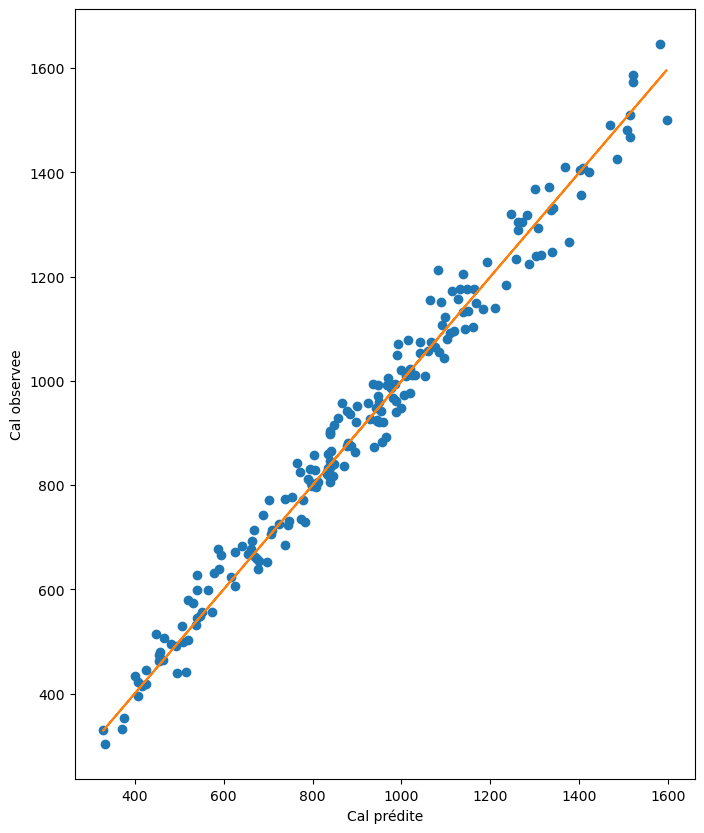

In [73]:
plt.plot(pred_DNN,YC_test,"o")
plt.plot(pred_DNN,pred_DNN)
plt.xlabel(u"Cal prédite")
plt.ylabel("Cal observee")
plt.show()